# Welcome to lab #2

In this section we will be utilizing the IMDB movie reviews dataset to classify the overall sentiment of reviews.

I generally think of sentiment in terms of two polar opposites. At the extreme negative scale you have -1 and at the positive 1. There are many variations on this floating around now like emotion classificaiton and the like but this is a good start!

You'll probably notice that this is very similar to the tutorial on Kera's website.

# What is our target?

Essentially your boss has given you the task of understanding sentiment across support tickets and you need to quickly go through a backlog and figure out which customers are angry and who isn't. You've done the basic research but need to go further.

How can we scalably do this?

# Acquire some data

Ideally you'd have endless hours to hire a team of annotators to label each support ticket, but we don't have time!

So what can we do instead? There is a fairly famous dataset already labeled for us using IMDB movie reviews.

* What are some issues you could see with using IMDB movie reviews for something like support tickets?
* How will we deal with things like out of vocabulary issues? For instance is Zendesk even in IMDB?
* How can we acquire new data to keep adding to our data stream?

# Compose the model

This is actually fairly straight forward. There are many many implementations of this ranging from using PyTorch to IBM Watson. Honestly they're all pretty good! You could even use a support vector machine to classify sentiment.

Nothing wrong with any of that. This is just one implementation.

LSTM - Long Short Term Memory is a great recurrent neural network to get the ball rolling. I have drastically cut down on the length of sequences and features so that we can do this as an exercise in the course.

## Questions to ask yourself

* What are the tradeoffs of using a deep learning architecture?
* Why would you _not_ want to use the LSTM below?
* Why would you _not_ want to use Keras, Tensorflow, PyTorch, or any of the other implementations of deep nets?

In [14]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.datasets import imdb
from keras.models import load_model

train = False
epochs = 2

max_features = 10000
maxlen = 50  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

if train:
    print('Build model...')
    model = Sequential()
    model.add(Input((50,)))
    model.add(Embedding(max_features, 128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test))

    model.save('../data/sentiment.h5')
else:
    model = load_model('../data/sentiment.h5')
    
print(model.input_shape)
    
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


(None, None)
782/782 [==============================] - 9s 11ms/step - loss: 0.4130 - accuracy: 0.8114
Test score: 0.4130210876464844
Test accuracy: 0.8113600015640259


In [15]:
def sentiment(open_texts):
    docs = map(lambda x: x.lower().split(), open_texts)
    lookup = imdb.get_word_index()
    arr = sequence.pad_sequences([
        [
            lookup.get(t, 0)
            for t in doc
            if lookup.get(t, 0) < max_features
        ]
        for doc in docs
    ], maxlen=maxlen)
    
    return 2*model.predict(arr) - 1

sentiment(['UGH I AM SO ANGRY', 'Neo is the one in the matrix'])

array([[-0.28072006],
       [ 0.6921593 ]], dtype=float32)

## Pretty good! But what on earth does this even mean?

Note that we are getting a fairly good training accuracy, validation accuracy is _ok_. 

What can we do with this? How would we present this to our boss?

# Transmitting and sustaining

This last bit is really the hard bit. We have done deep learning but we need to understand how to actually present this and understand our data better.

It's a prety common problem that one could just memorize databases and return a sentiment. That's not what we want. Does this even make sense?

We know that the validation accuracy is roughly 78% on a small epoch basis. This is ok for tutorial but what exactly does this say?

In [ ]:
# LIME and Shap Is what I wanted to use here but cannot since they are not up to date with tensorflow

In [19]:
import umap
import pandas as pd
import matplotlib.pyplot as plt

layer1 = model.layers[0]
layer1.trainable = False
layer2 = model.layers[1]
layer2.trainable = False

encoder = Sequential([layer1, layer2]) 

def encode(open_texts):
    '''
    Encodes using the sentiment analysis tool
    '''
    docs = map(lambda x: x.lower().split(), open_texts)
    lookup = imdb.get_word_index()
    arr = sequence.pad_sequences([
        [
            lookup.get(t, 0)
            for t in doc
            if lookup.get(t, 0) < max_features
        ]
        for doc in docs
    ], maxlen=maxlen)
    
    return encoder.predict(arr)

df = pd.read_csv('../data/IMDB Dataset.csv')
review_embeddings = encode(df['review'])

In [20]:
reducer = umap.UMAP()
u = reducer.fit_transform(review_embeddings)

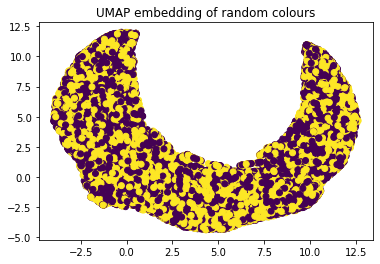

In [21]:
plt.scatter(u[:,0], u[:,1], c=df['sentiment'] == 'negative')
plt.title('UMAP embedding of the LSTM values');

In [31]:
import spacy
import numpy as np
# import tqdm

# nlp = spacy.load('en_core_web_sm')

# docs = []

# for d in tqdm.tqdm(df['review'].iloc[:1000], total=1000):
#     docs.append(nlp(d).vector)
    
# semantic_matrix = np.array(docs)
# np.save('../data/imdb_glove_vectors.npy', semantic_matrix)

In [32]:
semantic_matrix = np.load('../data/imdb_glove_vectors.npy')

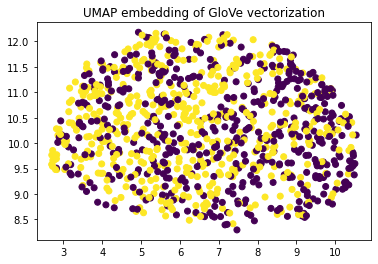

In [33]:
reducer = umap.UMAP()
u = reducer.fit_transform(semantic_matrix)

plt.scatter(u[:,0], u[:,1], c=df.iloc[:1000]['sentiment'] == 'negative')
plt.title('UMAP embedding of GloVe vectorization');

# What have we learned?

Deep learning is a difficult field to get your mind wrapped around. What have you learned? What would you show to your boss?